In [1]:
import model as m
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import odeint

In [2]:
#Load training data
train_images=np.load('Data_pendulum.npy')
train_images = train_images.reshape(train_images.shape[0], 29, 29, train_images.shape[3],1).astype('float32')

In [3]:
model = m.MODEL()#Create Model

In [4]:
# Load trained weights
model.load_weights('pendulum_results')

In [5]:
# Define function for CG evolution
def evolution_lib_pred(z, include_sine=True):
    a=np.zeros((1,101))
    a[0,0]=1.
    for i in range(1,51):
        a[0,i]=np.sin(z*i)
    for i in range(1,51):
        a[0,i+50]=np.cos(z*i)

    return a

In [6]:
thetaN=model.Theta.numpy()

In [7]:
def f(x,v_t,x_t,b):
    x_t1,v_t1 =x
    return (x_t1-x_t-0.05*v_t1,v_t1-v_t-evolution_lib_pred(x_t)@b)

In [8]:
#Do Predictions using MC
z1,t1=model.encode(train_images[1,:,:,:,:].reshape([1,29,29,75,1]))
res_mc=np.zeros((20,29,29,1,1000))
v_mc=np.zeros((20,1000))
x_mc=np.zeros((20,1000))
for mc in range(20):
    x_t=np.random.normal(z1[0,74],np.exp(0.5*t1[0,74]))
    v_t=np.random.normal(z1[0,148],np.exp(0.5*t1[0,148]))
    for i in range(1000):
        x_t1, v_t1 =  optimize.fsolve(f, (x_t, v_t),args=(v_t,x_t,thetaN))
        res_mc[mc,:,:,:,i]=model.decode(tf.reshape(x_t1,[1,1]), apply_sigmoid=True)
        v_mc[mc,i]=v_t1
        x_mc[mc,i]=x_t1
        x_t=x_t1
        v_t=v_t1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [9]:
res3=np.mean(res_mc,axis=0)
v=np.mean(v_mc,axis=0)
x=np.mean(x_mc,axis=0)

Text(0, 0.5, '$X_2$')

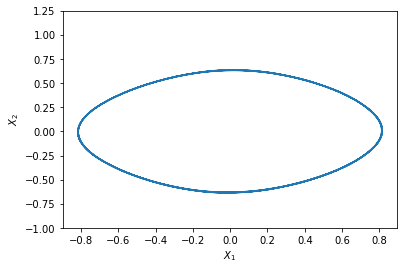

In [10]:
#Plot predicted Phase space
plt.plot(x,v)
plt.ylim(-1.0,1.25)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')

In [11]:
#Load Reference solution
x_ref=np.load('Reference_pendulum.npy')

Text(0.5, 1.0, 'Reference')

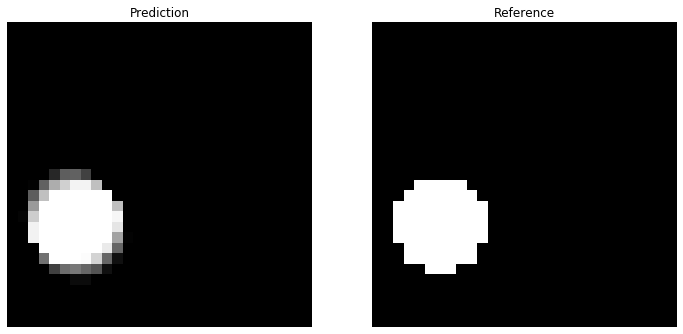

In [14]:
fig = plt.figure(figsize=(12,12))

i=250 #Time step i
plt.subplot(1, 2, 1)
plt.imshow(res3[:,:,0,i], cmap='gray')
plt.axis('off')
plt.title('Prediction')
plt.subplot(1, 2, 2)
plt.imshow(x_ref[0, :, :, i+75,0], cmap='gray')
plt.axis('off')
plt.title('Reference')